# RES 208: Graph Theory Final project

## Reddit's subreddits links graph exploration


[Alexandre Zouaoui](https://inzouzouwetrust.github.io/)

**Creation date:** 2017/07/02

**Updated:** 

*2018/04/19*
* Code refactoring
* Hiding credentials
* Ready to be shared on GitHub



### Introduction

As a long time [reddit](https://www.reddit.com) user, I decided to build my own dataset using Reddit [API](https://www.reddit.com/dev/api/). Reddit is an American website aggregating news and discussions about anything you could possibly imagine. Reddit is composed of *subreddits* which are forums nested in the website. Each subreddit has a unique name that relates to the topics that are discussed over there. Telling examples would be:

* [*r/worldnews*](https://www.reddit.com/r/worldnews/): where people discusses worldwide news and link to news articles.
* [*r/aww*](https://www.reddit.com/r/aww/): where people post pictures of cute animals.
* Not everything is in english. Each country has a devoted subreddit. France's is [*r/france*](https://www.reddit.com/r/france/).

And the list goes on. There are litteraly thousands of subreddits.

I am particularly interested in the relationships these subreddits have. One phenomenon that regularly occurs is when someone creates a thread on subreddit X that links directly to an other thread on subreddit Y. Redditors (people that browse Reddit) call this a *cross-post*.

My goal was therefore to create a graph that would show these relationships and apply the different algorithms we saw throughtout the course.

Luckily I did not have to start from scratch as there already exists a *Reddit bot* whose job consists in posting well-formatted comments on threads that have been cross-posted from another subreddit.

For instance, if someone on *r/france* posts a detailed thread (A) explaining in english how the French voting system works for people that browse *r/france* but do not read French very well, someone from *r/europe* might be inclined to cross-post this thread on *r/europe* (B). In that case, a bot named [*u/TotesMessenger*](https://www.reddit.com/r/TotesMessenger/wiki/index) automatically creates a comment in thread A comment section indicating that this posts has been directly linked by someone on *r/europe*.

Using the [PRAW: The Python Reddit API Wrapper](https://praw.readthedocs.io/en/latest/index.html) Python package I was able to retrieve such pairs of subreddits based on *u/TotesMessenger* comment history and I aggregated them into an Undirected Weighted graph. Undirected since when a thread is linked to another subreddit, said thread's subreddit is notified, so the relationship goes both way. Weighted since multiple threads from a given subreddit could have been linked to the same subreddit.

One big flaw lies in the capped number of comments one can browse using Reddit API. Using only one kind of comment ranking (based on *new*: new comments, *top*: most upvoted comments or *hot*: both new and highly upvoted comments) one can get only 1000 comments. This amounts to roughly 550 nodes and not so many more edges when using the *top* ranking.

In the following section I explain how I extracted the data after numerous tries. So far it has been the most exciting part of the project, since we had already applied the tools we studied in other lab sessions.

## Imports 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import praw # You might need to install this one
import pprint
import os
import re
import random

import networkx as nx

from scipy.stats import linregress
from scipy.special import zeta

import community

In [3]:
dataset_path = './dataset'

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

## Data download

To directly download the data, please open this Dropbox [link](https://www.dropbox.com/sh/syo0tscfn7tbgxs/AADs9fA-kYXxsz4UIQpjvTqMa?dl=0).

## Data extraction

### Identification

One needs to authentificate in order to use Reddit API.

I left my authentification scheme but feel free to use your own.

If you do not have one already, you might want to create one following this [tutorial](https://github.com/reddit/reddit/wiki/OAuth2-Quick-Start-Example#first-steps) first steps. 

In [4]:
# Get a read-only Reddit object instance

# To be able to add/modify/create Reddit content using a script,
# one needs to add its username and its password as arguments
    
if os.path.exists('./private'):
    from private import MY_CREDENTIALS
    my_reddit = MY_CREDENTIALS

else:
    my_reddit = praw.Reddit(client_id='input_your_client_id_here',
                     client_secret='input_your_client_password_here',
                     user_agent='input_your_custom_user_agent_here')

In [5]:
# Get a redditor object instance
redditor = my_reddit.redditor('TotesMessenger')

### Handy manipulations 

In this section I play with PRAW to highlight what we will later use to extract actual data.

In [6]:
# Get a ListGenerating object to iterate over in order to get the redditor's comments

list_generator = redditor.comments.new(limit=2) # Here we used 'new' as a comment ranking scheme

for comment in list_generator:
    # Get the subreddit name on which was posted the comment
    print("Subreddit on which was posted the comment: %s \n" % comment.subreddit_name_prefixed) 
    pprint.pprint("The comment itself...\n %s" % comment.body) # Get the comment content
    print("")

Subreddit on which was posted the comment: r/podemos 

('The comment itself...\n'
 ' Este hilo ha sido enlazado desde otro lugar en reddit.\n'
 '\n'
 '- [/r/u_riagch] [Sólo hay que echar un vistazo al programa de Ferreras para '
 'comprobar cómo están disfrutando con las desavenencias en PODEMOS. Desde '
 'Ferreras hasta los tertulianos pro PSOE, PP o C’s, exhiben sus sonrisas ante '
 'esta noticia. Los ilusos creen que es el fin de PODEMOS. Ladran, luego '
 'cabalgamos.](https://www.reddit.com/r/u_Riagch/comments/8dfcdr/sólo_hay_que_echar_un_vistazo_al_programa_de/)\n'
 '\n'
 '&nbsp;*^(Si sigues alguno de los links anteriores, por favor respeta las '
 'reglas de Reddit y no votes.) ^\\([Info](/r/TotesMessenger) ^/ '
 '^[Contactar](/message/compose?to=/r/TotesMessenger) ^/ '
 '^[¿Error?](/message/compose?to=/r/TotesMessenger&subject=translation%20error%20(Spanish\\)))*')

Subreddit on which was posted the comment: r/teenagers 

('The comment itself...\n'
 " I'm a bot, *bleep*, *bloop*.

To get the subreddit where *cross-posting* has happened, I need to retrieve the [r/genericSubredditName] part of the comment body. I use Python Regular Expression package (``re``) to do so.

### Actual extraction 

In [7]:
def extract_data(limit=None):
    """
    Extract the data using Reddit API via PRAW
    
    Input:
    limit: maximum number of comments to retrieve. (default: None - means as much as possible)
    
    Outputs:
    labels: dictionary with subreddits names as keys and their associated number in the graph as values
    edges: dictionary with subreddits number as keys and their associated dictionary as values
        Each key entry has a nested dictionary which contains the subreddits it is linked to as keys
            and the number of links as values (which will serve later as weight)    
    """


    labels = dict()
    edges = dict()
    index = 0
    
    

    for comment in redditor.comments.top(limit=limit):
        sub = comment.subreddit_name_prefixed

        if sub not in labels.keys():
            labels[sub] = index
            index += 1

        match = re.search(r'\[\/r\/\w+\]', comment.body).group(0)
        link = match[2 : len(match) - 1]

        if link not in labels.keys():
            labels[link] = index
            index += 1

        min_index, max_index = sorted((labels[sub], labels[link]))


        if min_index not in edges.keys():
            edges[min_index] = dict({max_index: 1})

        else:
            if max_index not in edges[min_index].keys():
                edges[min_index][max_index] = 1
            else:
                edges[min_index][max_index] += 1
    
    return labels, edges

In [8]:
labels, edges = extract_data()

In [9]:
print("Number of nodes in our dataset: %d" % len(labels))

Number of nodes in our dataset: 541


### Saving the data 

In [10]:
def dic_to_str(dic, nested=False):
    """
    Transform a dictionary to an adequate string to be later saved in the 'label.txt' and 'edge.txt' files.
    
    Inputs:
    dic: dictionary to be transformed
    nested: boolean equals to True in case edges dictionary is to be transformed (False by default)
    
    Output:
    string: resulting string
    """
    
    
    
    string = ""
    
    if nested:
        for key in dic.keys():
            for nested_key in dic[key].keys():
                string += str(key) + " " + str(nested_key) + " " + str(dic[key][nested_key]) + "\n"
            
    else:
        for key in dic.keys():
            string += key + "\n"
    
    return string

In [14]:
def save_data(labels=labels, edges=edges, dataset_path=dataset_path):
    """
    Save the data into 3 separate files : 'type.txt', 'label.txt' and 'edge.txt' to be used to import the graph
    
    Inputs:
    labels: dictionary with subreddits names as keys and their associated number in the graph as values
    edges: dictionary with subreddits number as keys and their associated dictionary as values
        Each key entry has a nested dictionary which contains the subreddits it is linked to as keys
            and the number of links as values (which will serve later as weight)
    directory: directory name (default: directory defined at the top)
    dataset: dataset name (default: subreddits)
    
    Output:
    True if no error encoutered
    """
    
    with open(dataset_path +  '/type.txt', 'w') as file:
        graph_type ="UW" # Undirected, Weighted graph
        file.write(graph_type)
        
    with open(dataset_path + '/label.txt', 'w') as file:
        data = dic_to_str(labels)
        file.write(data)
        
    with open(dataset_path +'/edge.txt', 'w') as file:
        data = dic_to_str(edges, nested=True)
        file.write(data)
        
    return True

In [15]:
save_data()

True

## Importing the graph

In [16]:
def import_graph(dataset_path=dataset_path):
    try:
        with open(dataset_path + "/type.txt", "r") as file:
            graph_type = file.readline()
        
        if graph_type == "DW": 
            G = nx.read_weighted_edgelist(dataset_path + "/edge.txt", 
                                          nodetype=int, 
                                          create_using=nx.DiGraph())
        elif graph_type == "UW": 
            G = nx.read_weighted_edgelist(dataset_path + "/edge.txt", nodetype=int)
        elif graph_type == "DU":
            G = nx.read_edgelist(dataset_path + "/edge.txt", 
                                 nodetype=int, 
                                 create_using=nx.DiGraph())
        else:
            G = nx.read_edgelist(dataset_path + "/edge.txt", 
                                 nodetype=int)
        G.name = "subreddits"
        
    except:
        G = nx.Graph(name = "Empty graph")
        
    return G

In [17]:
G = import_graph()

In [18]:
# Some info

print (nx.info(G))

Name: subreddits
Type: Graph
Number of nodes: 541
Number of edges: 635
Average degree:   2.3475


## Visualization 

In [19]:
pos = nx.spring_layout(G)
weights = nx.get_edge_attributes(G, 'weight')

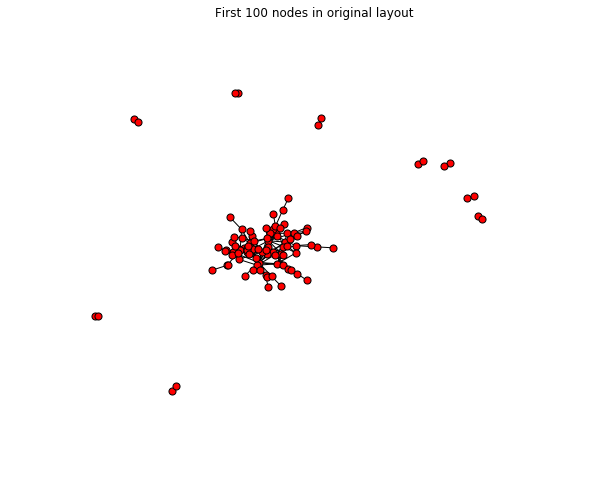

In [20]:
# Visualization

# Plotting the first 100 nodes using original graph layout
subgraph = nx.subgraph(G, G.nodes()[:100])


plt.figure(0, figsize=(10, 8))
plt.axis('off')
plt.title('First 100 nodes in original layout')
nx.draw_networkx_nodes(subgraph, pos, node_size=50)
nx.draw_networkx_edges(subgraph, pos)
plt.show()

First off, we notice that the graph is not connected. We can still retrieve the largest strongly connected component to get a better idea of the graph structure before using other metrics.

Largest connected component number of nodes: 439


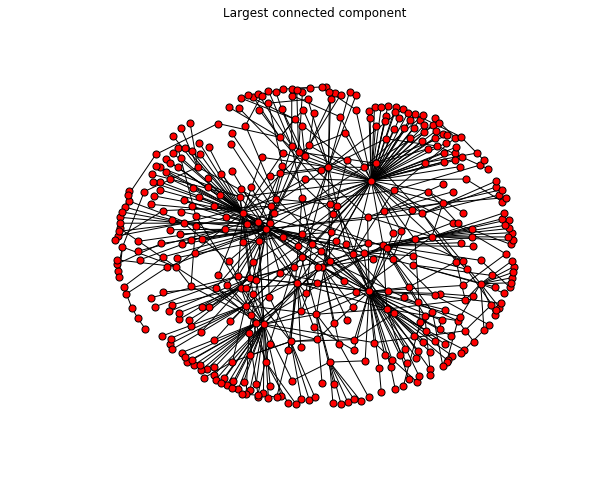

In [21]:
# Largest connected component

core = max(nx.connected_component_subgraphs(G), key=len)
core_pos = nx.spring_layout(core)

print("Largest connected component number of nodes: %d" % len(core))

plt.figure(1, figsize=(10, 8))
plt.axis('off')
plt.title('Largest connected component')
nx.draw_networkx_nodes(core, core_pos, node_size=50)
nx.draw_networkx_edges(core, core_pos)
plt.show()

## Degree metrics

In [22]:
# Build a dictionary with node degrees

node_degree = {node: G.degree(node) for node in G.nodes()}

degree_values = list(node_degree.values())

# Number of nodes

n = G.number_of_nodes()
print("Number of nodes: %d" % n)

# Maximum degree

max_degree = max(degree_values)
print("Maximum degree: %d" % max_degree)

# Minimum degree (we already know it is 1 by construction)

print("Minimum degree: %d" % min(degree_values))

# Average degree (we computed it earlier)

print("Average degree: %.2f" % np.mean(degree_values))

# Degree standard deviation

print("Standard deviation: %.2f" % np.std(degree_values))

# Largest component fraction
print("Largest component fraction: %.2f" % (len(core) / n))

# Normalized connected components number
print("Normalized connected components number: %.2f" % (nx.number_connected_components(G) / n))

# There is no isolated nodes by construction

Number of nodes: 541
Maximum degree: 69
Minimum degree: 1
Average degree: 2.35
Standard deviation: 4.99
Largest component fraction: 0.81
Normalized connected components number: 0.08


The standard deviation relatively high value is a first indicator that we might have a power law in our hands.

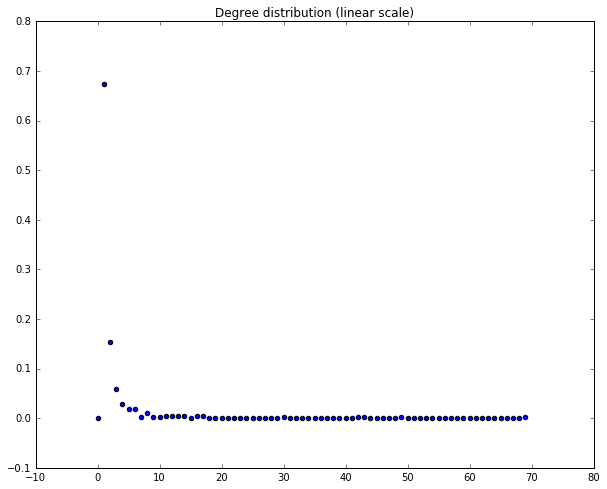

In [23]:
# Build degree distribution


N = np.zeros((max(degree_values) + 1))
p = np.zeros((max(degree_values) + 1))
for node in G.nodes():
    N[G.degree(node)] += 1
    p[G.degree(node)] += 1. / n
    
# Plot the degree distribution in linear scale

x_values = range(len(p))
y_values = [p[x] for x in x_values]
plt.figure(2, figsize=(10, 8))
plt.title("Degree distribution (linear scale)")
plt.scatter(x_values, y_values)
plt.show()

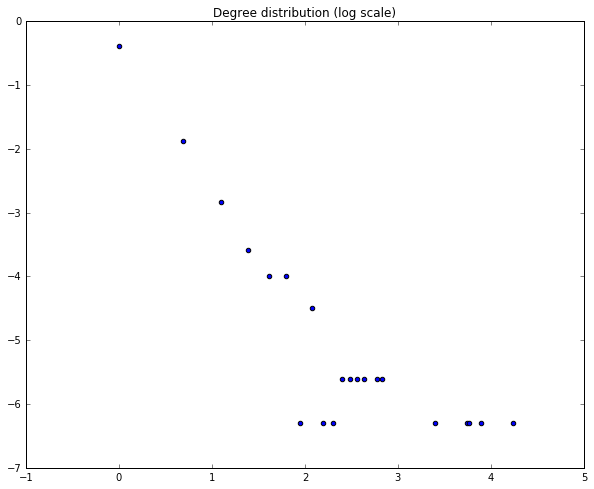

In [24]:
# Plot the degree distribution in logarithmic scale

x_values = [x for x in range(1, len(p)) if p[x] > 0]
y_values = [p[x] for x in x_values]
plt.figure(3, figsize=(10, 8))
plt.title("Degree distribution (log scale)")
plt.scatter(np.log(x_values), np.log(y_values))
plt.show()

This figure suggests that the degree distribution may follow a power law.

## Power law property 

In [25]:
# Computing some ratios

N_40 = np.sum(N[41:])
print("N40: %d" % N_40)
N_20 = np.sum(N[21:])
print("N20: %d" % N_20)
N_10 = np.sum(N[11:])
print("N10: %d" % N_10)

ratio_1 = N_40 / N_20
print("N40/N20 ratio: %.2f" % ratio_1)

ratio_2 = N_20 / N_10
print("N20/N10 ratio: %.2f" % ratio_2)

print("Relative gap: %.2f" % (abs(ratio_1 - ratio_2) / ratio_2))

N40: 4
N20: 5
N10: 17
N40/N20 ratio: 0.80
N20/N10 ratio: 0.29
Relative gap: 1.72


The $\frac{N_{40}}{N_{20}}$ and $\frac{N_{20}}{N_{10}}$ are not that close.

We can still compute the estimated $\gamma$.

In [26]:
# γ rough estimation

γ1 = 1 - log(ratio_1) / log(2)
print("N40/N20 ratio slopde absolute value: %.2f" % γ1)
γ2 = 1 - log(ratio_2) / log(2)
print("N40/N20 ratio slopde absolute value: %.2f" % γ2)

N40/N20 ratio slopde absolute value: 1.32
N40/N20 ratio slopde absolute value: 2.77


It triggers my curiosity to look deeper into what kind of slope we can get using a combination of logarithmic-binning and linear regression.

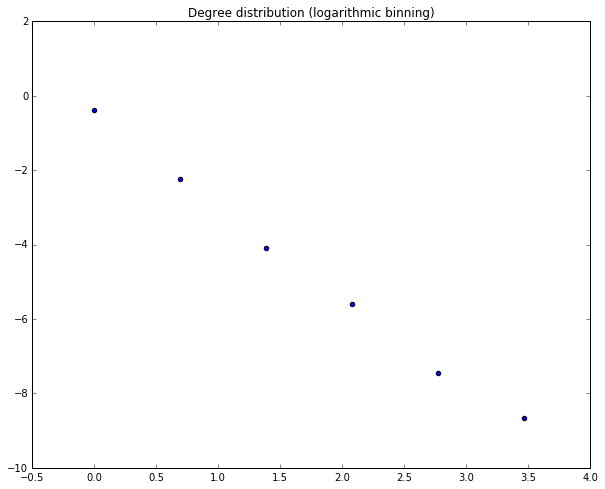

In [27]:
# Plotting degree distribution using logarithmic binning
warnings.filterwarnings("ignore")


n_bins = int(floor(log2(max_degree)) + 1)
Nbins = np.zeros(n_bins)
for b in range(n_bins):
    Nbins[b] = np.sum(N[2 ** b : min(2 ** (b + 1), max_degree)])
    
pbins = [Nbins[b] / (2 ** b * n) for b in range(n_bins - 1)]


x_values = [2 ** b for b in range(n_bins - 1)]
plt.figure(4, figsize=(10, 8))
plt.title("Degree distribution (logarithmic binning)")
plt.scatter(np.log(x_values), np.log(pbins))
plt.show()

In [28]:
# Linear regression on previous plot

linreg = linregress(np.log(x_values), np.log(pbins))
print("Linear Regression result:")
print(linreg)
print("Estimated value of γ: %.2f" % -linreg.slope)

Linear Regression result:
LinregressResult(slope=-2.410701760995556, intercept=-0.5640281842766264, rvalue=-0.9982026182606692, pvalue=4.842968381566001e-06, stderr=0.0723660235539355)
Estimated value of γ: 2.41


That is a higher value than what we estimated earlier.

To complete our Power Law analysis we might as well use Maximum Likelihood Estimation.

Distance minimizer: 1.91


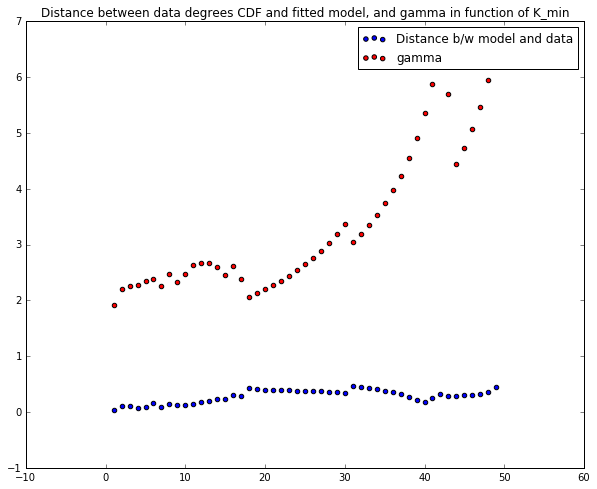

In [29]:
# Degree exponent estimation using Maximum Likelihood Estimation (lab 2 bonus)

degree_array = np.array(degree_values)

K_min_range = range(1, 50, 1)

D_array = np.empty(len(K_min_range))
γ_array = np.empty_like(D_array)

for i, K_min in enumerate(K_min_range):
    γ = 1. + 1. / np.mean(np.log(degree_array[degree_array >= K_min] / (K_min - .5)))
    P = 1. - zeta(γ, np.arange(K_min, max_degree + 1)) / zeta(γ, K_min - .5)
    S = np.cumsum(p[K_min:] / np.sum(p[K_min:]))
    D_array[i] = np.max(np.abs(S - P))
    γ_array[i] = γ
    
# Plotting γ and D in function of K_min

plt.figure(5, figsize=(10, 8))
plt.title("Distance between data degrees CDF and fitted model, and gamma in function of K_min")
plt.scatter(K_min_range, D_array, c='b', label='Distance b/w model and data')
plt.scatter(K_min_range, γ_array, c='r', label='gamma')
plt.legend(loc='best')
plt.plot()

# Retrieve γ that minimizes D

min_D_idx = np.where(D_array == np.min(D_array))

γ_star = γ_array[min_D_idx[0][0]]
print("Distance minimizer: %.2f" % γ_star)

** Power law conclusion: **

Needless to say that we get somewhat conflicting results.

After computing two ratios and obtaining two associated slopes, we got a higher absolute value using Linear Regression while Maximum Likelihood Estimation yields a gamma closer to our first ratio.

To conclude, while there seems to be a power law at play, it is not as strong as we could expect it to be if the graph were representing a social network with nodes being profiles. Here subreddits cannot quite be thought as profiles though they could be thought as Wikipedia pages. We may lack data as we were only able to retrieve approximately 550 nodes.  

## Label to node conversion 

In [31]:
def import_labels(dataset_path=dataset_path):
    labels = []
    
    with open(dataset_path + "/label.txt", "r") as file:
        for line in file:
            labels.append(line[0: -1])
    
    return labels

In [32]:
labels = import_labels()
node_from_label = {l: i for i, l in enumerate(labels)}

In [33]:
def get_nodelist_from_subreddit_name(name):
    rank = -1
    for node in G.nodes():
        if labels[node].find(name) >= 0:
            rank = node
            break
    return rank

In [34]:
rFrance_node = get_nodelist_from_subreddit_name("r/france")
rAnnouncements_node = get_nodelist_from_subreddit_name("r/announcements")

Let's assume the higher the weight, the fastest we can get into the next subreddit following this link.

Our distance metrics then becomes the inversed previous weights.

## Small world property

In [35]:
# Let's assume the higher the weight, the fastest we can get into the next subreddit following this link

# Our distance metrics then
weights_inv = nx.get_edge_attributes(G=G, name='weight')

for key in weights_inv:
    weights_inv[key] = 1 / weights_inv[key]
    
nx.set_edge_attributes(G=G, values=weights_inv, name='inverse weight')

In [36]:
# Shortest path length between r/france and r/announcements

nx.shortest_path_length(G, source=rFrance_node, target=rAnnouncements_node, weight='inverse weight')

2.083333333333333

In [37]:
def average_length_path(G, n_samples=100):
    
    """
    Computes the average length of the shorted paths between n_samples pairs of sources and targets chosen uniformly
    at random in the graph.
    
    Inputs:
    G: Graph on which is performed the computation
    n_samples: number of shortest paths between pairs of sources and targets to compute (default: 1000)
    
    Outputs:
    length_array: array of the shortest paths length of size n_samples
    """
    
    length_array = np.empty(n_samples)
    
    
    for i in range(n_samples):
        
        pair = random.sample(G.nodes(), 2)
        source = pair[0]
        target = pair[1]
        
        while (not nx.has_path(G, source, target)):
            pair = random.sample(G.nodes(), 2)
            source = pair[0]
            target = pair[1]
        
        length_array[i] = nx.shortest_path_length(G, source, target, weight='inverse weight')
    
    
    return length_array

In [38]:
length_array = average_length_path(G)
print("Average length path: %.2f" % (np.sum(length_array) / len(length_array)))

Average length path: 3.32


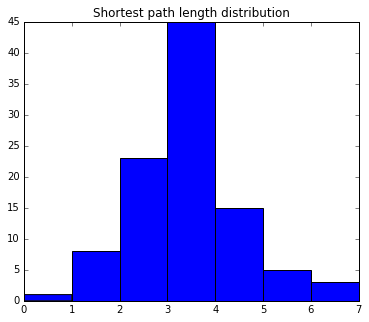

In [39]:
# Shortest path length distribution

plt.figure(6, figsize=(6, 5))
plt.title("Shortest path length distribution")
plt.hist(length_array, bins=range(8), range=[0, 8])
plt.show()

## Degree centrality

In [40]:
# Top 10 central nodes

decreasing_degree = sorted(labels, key=lambda x : G.degree(node_from_label[x]), reverse=True)
decreasing_degree[:10]

['r/madlads',
 'r/KenM',
 'r/Superbowl',
 'r/GamePhysics',
 'r/NoMansSkyTheGame',
 'r/badlegaladvice',
 'r/2016campaign',
 'r/firstworldanarchists',
 'r/france',
 'r/fakehistoryporn']

## Page Rank

In [41]:
dic = nx.pagerank(G, alpha=1/2)
sorted_nx_page_rank = sorted(labels, key=lambda x : dic[node_from_label[x]], reverse=True)
sorted_nx_page_rank[:10]

['r/madlads',
 'r/KenM',
 'r/GamePhysics',
 'r/Superbowl',
 'r/NoMansSkyTheGame',
 'r/2016campaign',
 'r/cableporn',
 'r/fakehistoryporn',
 'r/iamverysmart',
 'r/firstworldanarchists']

Notice how we got the exact same results in *approximately* the same order.

By the way I do not have a clue about what most of these subreddits are about.

### Betweenness centrality

In [42]:
# G Bipartition
print("Is G bipartite? %s" % nx.is_bipartite(G))

Is G bipartite? False


Hence we cannot compute the betweenness centrality using ``nx.betweenness_centrality`` function.

## Clustering

In [43]:
# Display the graph with its 16 largest clusters

def display_graph(G,com,pos,figsize = (8,8),node_size = 200,alpha = 0.5):
    color = ['r','b','g','c','m','y','k','0.8','0.2','0.6','0.4','0.7','0.3','0.9','0.1','0.5']
    k = min(len(color),len(com))
    length = [len(c) for c in com]
    index = np.argsort(-np.array(length))
    plt.figure(figsize=figsize)
    plt.axis('off')
    nx.draw_networkx_nodes(G,pos,node_size = node_size,node_color='w')
    nx.draw_networkx_edges(G,pos,alpha=alpha)
    for l in range(k):
        nx.draw_networkx_nodes(G,pos,node_size = node_size,nodelist = com[index[l]],node_color = color[l])
    plt.show()

In [44]:
def modularity_metrics(G, C):
    """
    Computes the partition precision, Simpson's index and modularity
    
    Inputs:
    G: graph on which is computed the modularity
    C: array of clusters
    
    Outputs:
    P: partition precision
    S_inv: inverse of Simpson's index
    Q: partition modularity
    """
    

    
    n_edges = G.number_of_edges()
    n = G.number_of_nodes()
    n_clusters = len(C)
    
    P = 0
    Q = 0
    
    S_inv = 1 / sum([len(cluster) ** 2 / n ** 2 for cluster in C])
    
    
    m = {i: 0 for i in range(n_clusters)}
    h = {i: 0 for i in range(n_clusters)}
    
    for i, cluster in enumerate(C):
        sub_G = nx.subgraph(G, cluster)
        m[i] = sub_G.number_of_edges() / n_edges
        
    
    for i, cluster in enumerate(C):
        h[i] = sum([nx.degree(G, node) for node in cluster]) ** 2 / (2 * n_edges) ** 2
        
    P = sum(list(m.values()))
    
    Q = P - sum(list(h.values()))
    
    
    return P, S_inv ,Q

In [45]:
# Louvain's optimized algorithm

def louvain(G, sigma = 1):
    return community.best_partition(G, resolution = 1. / sigma)

In [46]:
def dict2list(com):
    listC = []
    C = []
    for u,k in com.items():
        if k not in listC:
            listC.append(k)
            C.append([u])
        else:
            C[listC.index(k)].append(u)
    return C

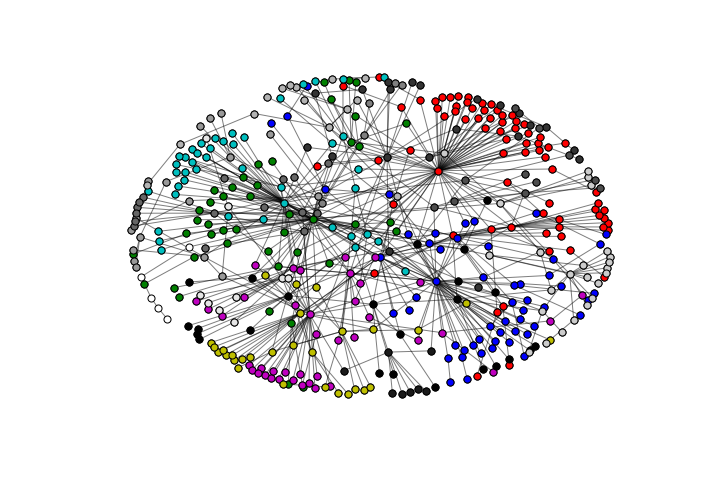

Precision: 0.76
Inverse Simpson's index: 11.10
Modularity: 0.67



In [47]:
# Clustering on core component
com = louvain(core)
C = dict2list(com)
display_graph(core, C, core_pos, figsize=(12, 8), node_size=50)

print("Precision: %.2f\nInverse Simpson's index: %.2f\nModularity: %.2f\n" % (modularity_metrics(core, C)))

We could expect up to 9 clusters on the core component according to Simpson's index

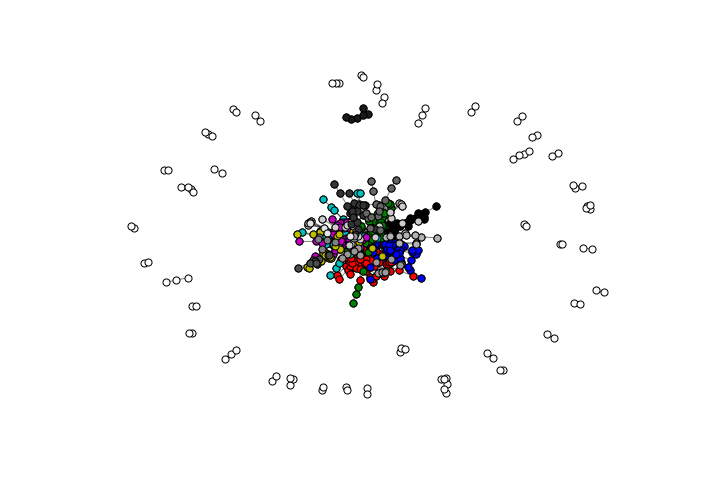

Precision: 0.79
Inverse Simpson's index: 14.56
Modularity: 0.70



In [48]:
# Clustering on entire graph
com = louvain(G)
C = dict2list(com)
display_graph(G, C, pos, figsize=(12, 8), node_size=50)

print("Precision: %.2f\nInverse Simpson's index: %.2f\nModularity: %.2f\n" % (modularity_metrics(G, C)))

This clustering visualization is not satisfying but time is running out.

### Conclusion:

There is much more to explore on this original dataset.

Besides the endless different strategies to aggregate the data that we could have used (such as pipelining different ListGenerator to get more edges but maybe also redundant connections), we were still able to compute basic metrics we studied in class.

I am glad this dataset worked out since I was skeptical at first when I saw the average degree been so low (around 2).

Although the Power Law beneath the degree distribution is not clear cut, this particular degree distribution provides yet another example that Erdös-Rényi graphs are not able to accurately describe real data graphs.